In [1]:
from music21 import converter, instrument, note, chord, stream
from collections import Counter

import numpy as np

import glob
import pickle

In [2]:
# параметры модели
batch_size     = 20
sequence_size  = 100
embedding_size = 200
hidden_size    = 400 

n_epochs = 300

## Подготовка данных

In [3]:
def get_notes(dir_notes, file_output):
    """ функция просматривает все mid/midi файлы в заданной директории
        и возвращает список нот/аккордов фортепиано из этих файлов 
    """
    notes = []
    
    for file in glob.glob(dir_notes + "*.mid*"):
        midi = converter.parse(file)
       
        print("checking", file)

        notes_to_parse = None
        
        # получение нот/аккордов из файла, в зависимости типа midi файла
        try:
            stream = instrument.partitionByInstrument(midi)
            notes_to_parse = stream.parts[0].recurse() 
        except:
            notes_to_parse = midi.flat.notes
         
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
               
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
    
    # сохранение списка нот в файл "file_output"
    with open(file_output, 'wb') as f:
        pickle.dump(notes, f)
    
    print("total notes:", len(notes))
          
    return notes    

In [5]:
# Парсинг двух датасетов. Так как процесс длительный,
# лучше загрузить ноты из сохраненных файлов.

#notes1 = get_notes("data/dataset_ibi/", "data/notes_ibi")

checking dataset_ibi/Medicine.mid
checking dataset_ibi/Hammering.mid
checking dataset_ibi/Liquorice.mid
checking dataset_ibi/Hans Zimmer - Interstellar Theme.mid
checking dataset_ibi/Cotton.mid
checking dataset_ibi/1000 Doors.mid
checking dataset_ibi/Walzer Nr. 2.mid
checking dataset_ibi/Harry Escott - Unravelling.mid
checking dataset_ibi/Unkenrufe.mid
checking dataset_ibi/Bebelplatz.mid
checking dataset_ibi/Ohm.mid
checking dataset_ibi/C418 - Wet Hands.mid
checking dataset_ibi/Petting the keys.mid
checking dataset_ibi/Joseph Trapanese - Arctic.mid
checking dataset_ibi/Hände waschen.mid
checking dataset_ibi/Chris Isaak - Wicked Game.mid
checking dataset_ibi/Short.mid
checking dataset_ibi/Joseph Trapanese Arctic (live).mid
checking dataset_ibi/Some Sand.mid
checking dataset_ibi/Not_Quite.mid
checking dataset_ibi/Peeling and shaving the balls.mid
checking dataset_ibi/Massive Attack - Teardrop (ibi).mid
checking dataset_ibi/Wunden lecken.mid
checking dataset_ibi/Breakfast.mid
checking dat

In [43]:
#notes2 = get_notes("data/dataset_classic/", "data/notes_classic")

checking dataset_classic/MIDI-Unprocessed_XP_04_R1_2004_06_ORIG_MID--AUDIO_04_R1_2004_08_Track08_wav.midi
checking dataset_classic/MIDI-Unprocessed_XP_03_R1_2004_01-02_ORIG_MID--AUDIO_03_R1_2004_01_Track01_wav.midi
checking dataset_classic/MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_05_Track05_wav.midi
checking dataset_classic/MIDI-Unprocessed_SMF_16_R1_2004_01-08_ORIG_MID--AUDIO_16_R1_2004_13_Track13_wav.midi
checking dataset_classic/MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_10_Track10_wav.midi
checking dataset_classic/MIDI-Unprocessed_SMF_17_R1_2004_01-02_ORIG_MID--AUDIO_20_R2_2004_02_Track02_wav.midi
checking dataset_classic/MIDI-Unprocessed_SMF_07_R1_2004_01_ORIG_MID--AUDIO_07_R1_2004_02_Track02_wav.midi
checking dataset_classic/MIDI-Unprocessed_XP_01_R1_2004_03_ORIG_MID--AUDIO_01_R1_2004_04_Track04_wav.midi
checking dataset_classic/MIDI-Unprocessed_SMF_17_R1_2004_01-03_ORIG_MID--AUDIO_17_R1_2004_06_Track06_wav.midi
checking dataset_class

In [4]:
# загрузка нот из готовых файлов

# список содержит ноты всех mid/midi файлов,
# которые НЕ разделяются специальными символами
notes = []

with open('data/notes_ibi', 'rb') as f:
    notes += pickle.load(f)
    
with open('data/notes_classic', 'rb')as f:
    notes += pickle.load(f)

In [5]:
# делаем словари нот
dict_notes = Counter(notes)

sorted_notes = sorted(dict_notes, key=dict_notes.get, reverse=True)

int_to_note = {i : n for i,n in enumerate(sorted_notes)}
note_to_int = {n : i for i,n in enumerate(sorted_notes)}

# количество уникальных нот
n_notes = len(int_to_note)

# заменяем в списке notes все ноты на натуральные числа и исчитаем batch_size
int_notes = [note_to_int[note] for note in notes]
num_batches = int(len(int_notes) / (sequence_size * batch_size))

# входные данные для нейросети
input_notes = int_notes[:num_batches * batch_size * sequence_size]

# выходные данные есть смещенные на 1 позицию влево входные данные
output_notes = np.zeros_like(input_notes)
output_notes[:-1] = input_notes[1:]
output_notes[-1] = input_notes[0]

# изменяем размеры входных/выходных данных
input_notes = np.reshape(input_notes, (batch_size, -1))
output_notes = np.reshape(output_notes, (batch_size, -1))

# получение мини-батчей
def get_batches(input, output, batch_size, seq_size):
    num_batches = np.prod(input.shape) // (seq_size * batch_size)
    for i in range(0, num_batches * seq_size, seq_size):
        yield input[:, i:i+seq_size], output[:, i:i+seq_size]

In [6]:
print("notes in all files:", len(notes))
print("unique notes:", n_notes)
print("number of batches:", num_batches)

notes in all files: 320816
unique notes: 913
number of batches: 160


## Обучение модели

In [7]:
import torch
import torch.nn as nn
from model import RNNModule

# по-умолчанию torch.device('cude'), если cuda доступно, иначе 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

True


In [8]:
# класс модели описан в файле model.py

net = RNNModule(sequence_size, hidden_size, embedding_size, batch_size, n_notes)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), 0.001)

iteration = 0

acc_values = []
loss_values = []

for epoch in range(1,n_epochs + 1):
    batches = get_batches(input_notes, output_notes, batch_size, sequence_size)
    
    state_h, state_c = net.zero_state(batch_size)
    
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    
    
    loss_value = 1
    acc = 0
    
    for x, y in batches:
        iteration += 1
        net.train()
        
        # выполняем прямой ход, считаем loss и корректируем параметры сети
        optimizer.zero_grad()
        
        x = torch.tensor(x).to(device)
        y = torch.tensor(y).to(device)
        
        logits, (state_h, state_c) = net(x, (state_h, state_c))
        
        loss = criterion(logits.transpose(1, 2), y)
        loss_value = loss.item()
        loss.backward()
        
        state_h = state_h.detach()
        state_c = state_c.detach()

        # ограничиваем размер градиентов
        _ = torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
        
        # считаем точность на текущей итерации
        _, pred = torch.max(logits.transpose(1, 2).data, 1)
        acc = (pred == y).sum().item() / (y.size(0) * y.size(1))
       
        optimizer.step()
        
        # выводим состояние сети каждые 200 итераций
        if iteration % 200 == 0:
            print('Epoch: {}/{}'.format(epoch, n_epochs),
                  'Iteration: {}'.format(iteration),
                  'Loss: {}'.format(loss_value))
            print('Accuracy: {}'.format(acc))
        
        # сохраняем параметры сети каждые 1000 итераций
        if iteration % 1000 == 0:
            torch.save(net.state_dict(),
                       'data/model_states/model-{}.pth'.format(iteration))
            
    # сохраняем значения accuracy и loss, чтобы сделать графики
    acc_values.append(acc)
    loss_values.append(loss_value)
    

torch.save(net.state_dict(),'data/model_states/model-final.pth')

Epoch: 2/300 Iteration: 200 Loss: 4.221468925476074
Accuracy: 0.0825
Epoch: 3/300 Iteration: 400 Loss: 3.8929240703582764
Accuracy: 0.1565
Epoch: 4/300 Iteration: 600 Loss: 3.9534733295440674
Accuracy: 0.1355
Epoch: 5/300 Iteration: 800 Loss: 3.767775297164917
Accuracy: 0.1225
Epoch: 7/300 Iteration: 1000 Loss: 3.6655657291412354
Accuracy: 0.162
Epoch: 8/300 Iteration: 1200 Loss: 3.471611738204956
Accuracy: 0.196
Epoch: 9/300 Iteration: 1400 Loss: 3.5584139823913574
Accuracy: 0.1765
Epoch: 10/300 Iteration: 1600 Loss: 3.4369916915893555
Accuracy: 0.194
Epoch: 12/300 Iteration: 1800 Loss: 3.328564405441284
Accuracy: 0.2255
Epoch: 13/300 Iteration: 2000 Loss: 3.149411678314209
Accuracy: 0.266
Epoch: 14/300 Iteration: 2200 Loss: 3.23767352104187
Accuracy: 0.237
Epoch: 15/300 Iteration: 2400 Loss: 3.1233954429626465
Accuracy: 0.2585
Epoch: 17/300 Iteration: 2600 Loss: 3.009507179260254
Accuracy: 0.2895
Epoch: 18/300 Iteration: 2800 Loss: 2.8746564388275146
Accuracy: 0.3105
Epoch: 19/300 It

Epoch: 144/300 Iteration: 23000 Loss: 1.188928246498108
Accuracy: 0.665
Epoch: 145/300 Iteration: 23200 Loss: 1.2167247533798218
Accuracy: 0.671
Epoch: 147/300 Iteration: 23400 Loss: 1.139841914176941
Accuracy: 0.6745
Epoch: 148/300 Iteration: 23600 Loss: 1.0713694095611572
Accuracy: 0.707
Epoch: 149/300 Iteration: 23800 Loss: 1.1886399984359741
Accuracy: 0.67
Epoch: 150/300 Iteration: 24000 Loss: 1.1945141553878784
Accuracy: 0.6655
Epoch: 152/300 Iteration: 24200 Loss: 1.1114977598190308
Accuracy: 0.6815
Epoch: 153/300 Iteration: 24400 Loss: 1.0617064237594604
Accuracy: 0.6945
Epoch: 154/300 Iteration: 24600 Loss: 1.1866397857666016
Accuracy: 0.6595
Epoch: 155/300 Iteration: 24800 Loss: 1.1728237867355347
Accuracy: 0.6745
Epoch: 157/300 Iteration: 25000 Loss: 1.0592496395111084
Accuracy: 0.704
Epoch: 158/300 Iteration: 25200 Loss: 1.019850254058838
Accuracy: 0.7085
Epoch: 159/300 Iteration: 25400 Loss: 1.1714589595794678
Accuracy: 0.6695
Epoch: 160/300 Iteration: 25600 Loss: 1.1638494

Epoch: 284/300 Iteration: 45400 Loss: 0.8768768906593323
Accuracy: 0.741
Epoch: 285/300 Iteration: 45600 Loss: 0.8768104314804077
Accuracy: 0.7485
Epoch: 287/300 Iteration: 45800 Loss: 0.7468906044960022
Accuracy: 0.7865
Epoch: 288/300 Iteration: 46000 Loss: 0.8251441717147827
Accuracy: 0.7585
Epoch: 289/300 Iteration: 46200 Loss: 0.871966540813446
Accuracy: 0.7555
Epoch: 290/300 Iteration: 46400 Loss: 0.9199639558792114
Accuracy: 0.734
Epoch: 292/300 Iteration: 46600 Loss: 0.7130383253097534
Accuracy: 0.779
Epoch: 293/300 Iteration: 46800 Loss: 0.8307287693023682
Accuracy: 0.767
Epoch: 294/300 Iteration: 47000 Loss: 0.9402204155921936
Accuracy: 0.723
Epoch: 295/300 Iteration: 47200 Loss: 0.918623685836792
Accuracy: 0.742
Epoch: 297/300 Iteration: 47400 Loss: 0.6915026903152466
Accuracy: 0.791
Epoch: 298/300 Iteration: 47600 Loss: 0.8059830069541931
Accuracy: 0.758
Epoch: 299/300 Iteration: 47800 Loss: 0.9110283255577087
Accuracy: 0.73
Epoch: 300/300 Iteration: 48000 Loss: 0.8925164341

In [9]:
import matplotlib.pyplot as plt

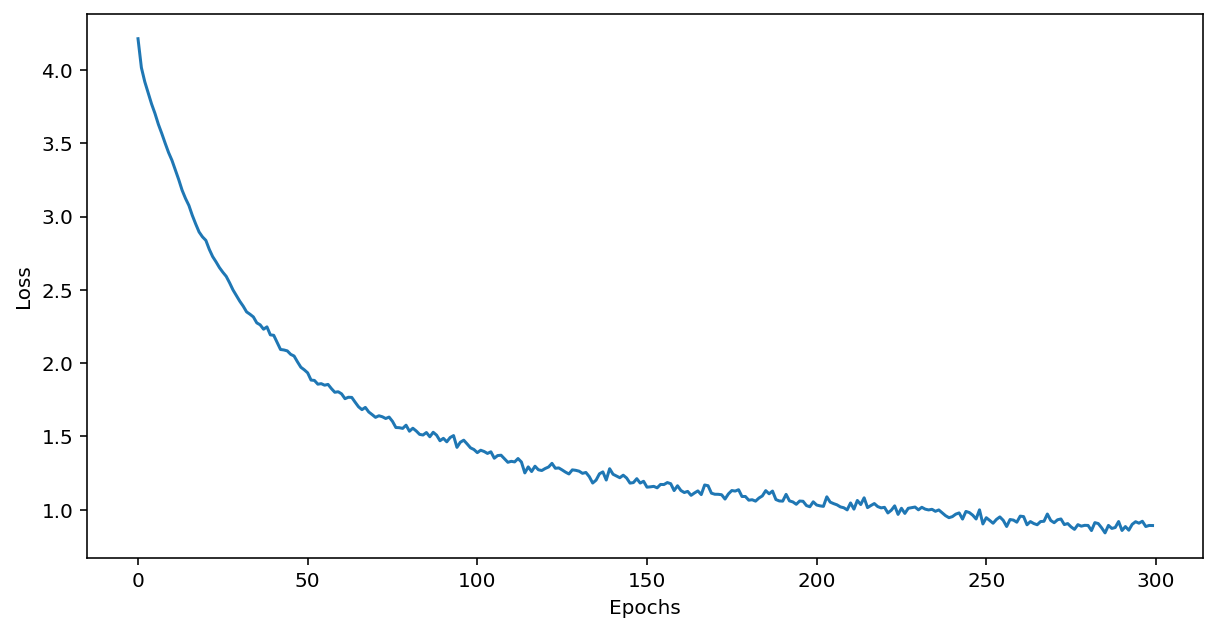

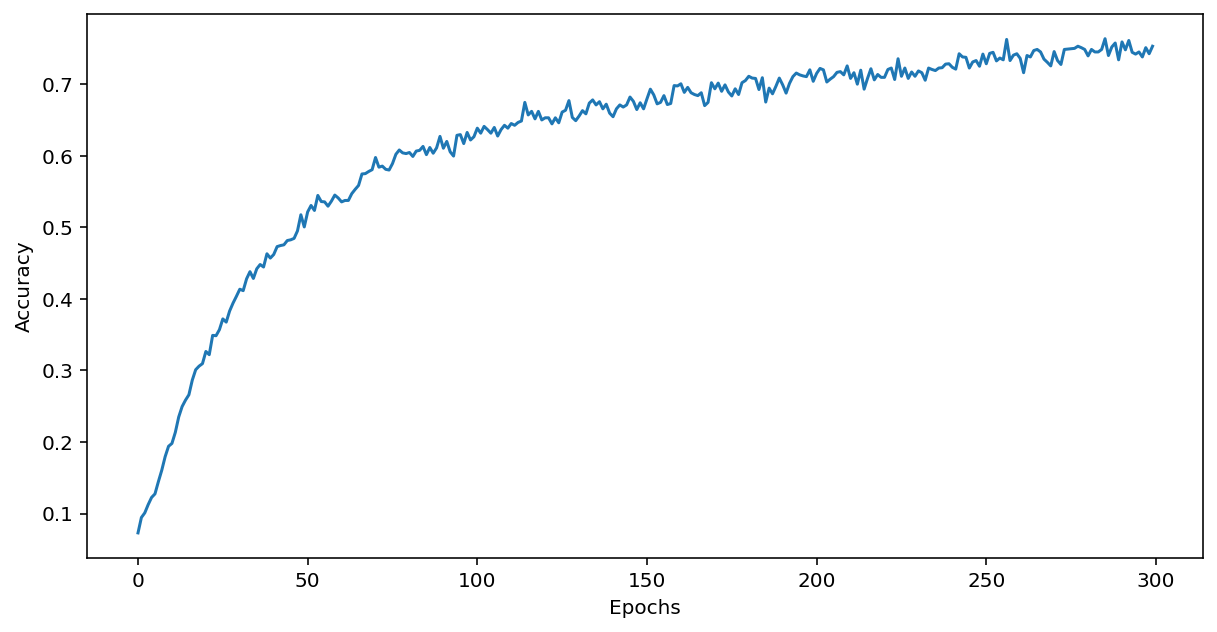

In [10]:
# изображение loss и accuracy на графиках
x = np.arange(len(acc_values))

plt.rcParams['figure.figsize'] = (10,5)

plt.figure(1)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(x,loss_values)

plt.figure(2)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(x,acc_values)

plt.show()

# На эпохе 282 (45000 итераций) точность модели была наибольшей. (0.7905)
# Поэтому при генерации mid будем использовать состояния модели 188 эпохи.